### DATA 620
### Project 2: 2-Mode Networks

__Team:__ Data Owls  
__Members:__ Keith Folsom, Valerie Briot
    
__Date:__ 10/12/2017
    
### Project Overview

This project is a continuation of the network analysis performed on the Yelp dataset for Project 1, which is located here: (https://github.com/kfolsom98/DATA620/blob/master/Project1/code/DataOwls_Project1_final.ipynb). However, unlike Project 1, the ensuing analysis will look at the Yelp dataset as a bimodal or 2-mode network of users and buseiness.  

The businesses considered below are all restaurants in the Pittsburgh area with a review made during the 2014 and 2015 timeframe.  All Yelp users who have submitted a review of a Pittsburg restaurant during this timeframe will be included in this reduced 2-mode network.

### Background 

The Yelp Business Review dataset is located here https://www.yelp.com/dataset/download as a reference. 
Due to the volume of data in the current Yelp dataset, the 2015 Yelp Business Review dataset was be used due to its smaller volume.

The Yelp dataset is available in JSON or SQL format. Ultimately the JSON files noted below were used:
File	Size
business.json	54 MB
user.json	158 MB
review.json	1.32 GB

Yelp is a crowd-sourced local business review and social networking site. Users can submit a review for products and services using a 1 to 5 start rating system.

For the purposes of this project, we will consider the Businesses and Users and bipartite nodes.  The business reviews created by users will provide the edgelist between the network nodes.

User-based reviews such as the Yelp dataset make for a natural bipartite graph with a 2-node types network with the two nodes being businesses and users.  The analysis below will examine businesses and users using the bipartite weighted projection method to study them as 1-mode networks.



### Data Preparation

Load the necessary Python packages and source the Pittsburg Business, Users, and Reviews.

In [1]:
import community
from community import community_louvain
import networkx as nx
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter


# set the default plot size
plt.rcParams['figure.figsize'] = (25, 15)

# hide warnings thrown from Python 2 to 3
import warnings
warnings.filterwarnings("ignore")


#### Import CSV files from GitHub

##### Pittsburgh Businesses

In [2]:
GitHub = "https://raw.githubusercontent.com/kfolsom98/DATA620/master/Project2/data/"

In [4]:
file = GitHub + "Businesses_Pittsburg.csv"
business = pd.read_csv(file,  header=0, encoding="latin-1")

## 1217 business
business.shape

(1217, 8)

In [3]:
business.head(5)

,business_id,name,full_address,categories,city,state,review_count,neighborhoods
0,wqu7ILomIOPSduRwoWp4AQ,Denny's,"2180 Greentree Rd\r\nPittsburgh, PA 15220","c(""Breakfast & Brunch"", ""American (Traditional...",Pittsburgh,PA,7,character(0)
1,_jsJFrAmFVPRio0eEVExbA,McDonald's,4557 Ohio River Blvd\r\nBellevue\r\nPittsburgh...,"c(""Burgers"", ""Fast Food"", ""Restaurants"")",Pittsburgh,PA,4,Bellevue
2,udZJ8YgsHdqtFDQkyPTV1Q,Arby's Roast Beef Restaurants,4260 Ohio River Blvd\r\nBellevue\r\nPittsburgh...,Restaurants,Pittsburgh,PA,3,Bellevue
3,ZL6DNzyenFm9Kpz6uADlNg,Pino's Contemporary Italian Restaurant & Wine Bar,6738 Reynolds St\r\nPoint Breeze\r\nPittsburgh...,"c(""Tapas/Small Plates"", ""Restaurants"", ""Italian"")",Pittsburgh,PA,46,Point Breeze
4,OcTG-KzDleuRub-pb6JS3Q,Eddie's Pizza Haus,"1744 Chislett St\r\nMorningside\r\nPittsburgh,...","c(""Pizza"", ""Restaurants"")",Pittsburgh,PA,5,Morningside


#### Users Connected to Pittsburgh Business Reviews

In [5]:
file = GitHub + "Users_Pittsburg.csv"
user = pd.read_csv(file,  header=0, encoding="latin-1")

## 9189 business
user.shape

(9189, 6)

In [74]:
user.head(5)

,user_id,name,average_stars,review_count,fans,yelping_since
0,RfBKeYFffFZ9qx6EcSzdaA,Phil,2.67,4,0,2013-10
1,VpsFsXYiVGmsBprr9Onb0Q,Amanda,4.00,7,0,2014-01
2,nVSpJQC1ULMKgiC8ItT6sQ,Robert,3.56,10,0,2014-05
3,G_BvSxt71MqF_x4jgEyqSA,Shari,4.34,97,7,2008-11
4,nuW7cTZhuSRupXeFbNMSRg,Joe,3.33,6,0,2011-01


##### Reviews of the Pittsburgh Restaurants 

In [6]:
file = GitHub + "Reviews_Pittsburg.csv"
review = pd.read_csv(file,  header=0)

## 23339 non-distinct reviews  by user_id, business_id
review.shape

# drop the stars (rating) column
review.drop(review.columns[2],axis=1,inplace=True)

# deduplicate 
review = review.drop_duplicates()

## 22934 distinct reviews
review.shape

(22934, 2)

In [7]:
review.head(5)

,user_id,business_id
0,CiCmxCruMvbXtjQP5FhbLg,wqu7ILomIOPSduRwoWp4AQ
1,bbYn77XD_aAeFL-lwV7GBA,wqu7ILomIOPSduRwoWp4AQ
2,UxfFAw2-cTpeWvRROF1HEw,wqu7ILomIOPSduRwoWp4AQ
3,3eystYBQINAG1tlRBk215A,wqu7ILomIOPSduRwoWp4AQ
4,vQPRddwB2m9se3GDM05eGw,_jsJFrAmFVPRio0eEVExbA


#### Created a Bipartite Graph of Bussinesses and Users

In [8]:

G = nx.Graph()

# Create the business nodes with attributes - name, categories, and neighborhoods.
for index, row in business.iterrows():
    # print(row['business_id'])
    G.add_node(row['business_id'],
               bipartite=0,
               name=row['name'],
               categories=row['categories'],
               neighborhoods=row['neighborhoods'])
             

# Create the user nodes with attributes - name, categories, and neighborhoods.  
# Categories and neighborhoods are null for users but included for node attribute consistency 
# between businesses and users
for index, row in user.iterrows():
    # print(row['business_id'])
    G.add_node(row['user_id'],
               bipartite=1,
               name=row['name'],
               categories=None,
               neighborhoods=None)

# edges
G.add_edges_from([(row['business_id'], row['user_id']) for idx, row in review.iterrows()])

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10405
Number of edges: 22934
Average degree:   4.4083


We see the Yelp business and user bipartite network has 10,405 nodes with 22,934 edges.  Let's check some network characteristics:

In [9]:
print("Bipartite Network G\n  Bipartite: {}\n  Connected: {}".format(nx.is_bipartite(G), 
                                                                 nx.is_connected(G)))

Bipartite Network G
  Bipartite: True
  Connected: False


Since the network has some unconnected subgraphs, we'll remove these and work on the largest connected subgraph.  The subgraphs being removed all have 5 or less nodes.  This takes the overall nodes down from 10,405 to 10,192.

In [10]:
subgraphs = nx.connected_component_subgraphs(G)

Gsub = max(nx.connected_component_subgraphs(G), key=len)

print(nx.info(Gsub))

Name: 
Type: Graph
Number of nodes: 10192
Number of edges: 22891
Average degree:   4.4920


Calculate the network density.  This is a fairly resource-intensive calculation for this size network. Once the shortest path length from every node to all other nodes is calculated, the diameter is the longest of all the calculated path lengths. The diameter is representative of the linear size of a network.

In [17]:
print('Network diameter =', nx.diameter(Gsub))

In [ ]:
The network diameter is 10.

### Create Bipartite Node Sets for Users and Businesses


In [11]:
users, businesses = nx.bipartite.sets(Gsub)

len(users), len(businesses)

(9146, 1046)

In [80]:
# let's check the density of the user nodes
nx.bipartite.density(Gsub, users)

0.002392775117396607

It's interesting to note here that the user network is not particularly dense.  This will be explored more below.

### Create the weighted projected graph of User and Businesses.

In [12]:
U = nx.bipartite.weighted_projected_graph(Gsub, users, ratio=False)

In [13]:
B = nx.bipartite.weighted_projected_graph(G, businesses, ratio=False)

Let's look at the resulting weighted projected graph of users.

In [14]:
print(nx.info(U))

Name: 
Type: Graph
Number of nodes: 9146
Number of edges: 696786
Average degree: 152.3696


In [15]:
triadic_closure = nx.transitivity(U)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.33138271140390124


Again, looking at the transitivity value of the User network U, we see a value lower than might be expected given that there is a finite number of restaurants in Pittsburgh being reviewed.  As a ratio, it's roughly 1 business for every 9 users.

In [16]:
# Business projected graph information
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 1046
Number of edges: 85125
Average degree: 162.7629


## Communities Within  the User Nodes

To understand what the weighted projected user network looks like, let's examine the communities within the network.  Communities are identified using the Louvain detection method.  Generally, commmunities are nodes within the network that are more densely connected to each other than other nodes, or the concept of modularity.

In [17]:
partitions = community_louvain.best_partition(U)

In [18]:
set(partitions.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

There are over 10 different communities within the user network. Known as modularity, this provides a sense of how fractured the network is.

Let's plot the communities.  Again an intensive operation but an interesting visual of the communities within the user network.

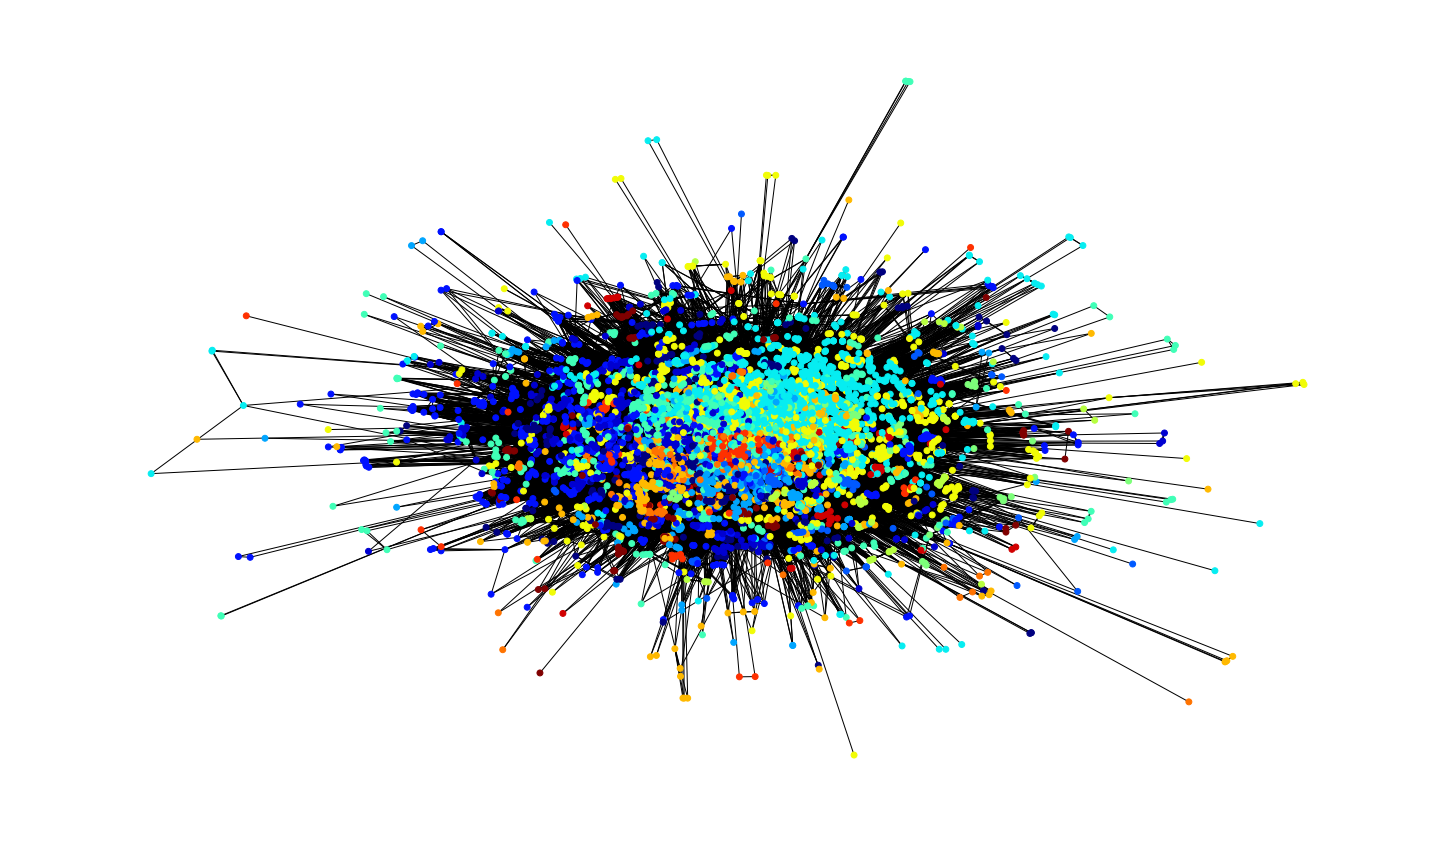

In [39]:
values = [partitions.get(node) for node in U.nodes()]
spring_pos = nx.spring_layout(U)
plt.axis("off")
nx.draw_networkx(U, pos = spring_pos, 
                 cmap = plt.get_cmap("jet"), node_color = values, 
                 node_size = 35, with_labels = False)

In [19]:
# Assign the partition (modularity score) to the user nodes for later use
nx.set_node_attributes(U, 'partition', partitions)

In [20]:
partitions_df = pd.DataFrame({'partition':partitions})

#### Distribution of Users Within Communities

In [23]:

# function to generate histogram

def plot_dist(df, range, bins):

    # Plot the distribution of users within each community
    sns.set_style("whitegrid")    # Set style for seaborn output
    sns.set_context("notebook", font_scale=1.5)
    plt.figure(figsize=(8,8))
    plt.xticks(range) #np.arange(0,15,1))
    plt.xlabel("Partition")
    plt.ylabel("Frequency")
    plt.title("Distribution of Users Within Communities", fontsize=16)

    sns.distplot(partitions_df, bins=bins, kde=False, rug=False);
    

Plot the distribution on user nodes by partition as seen below.  One partition in particular, 6, has the most users nodes.

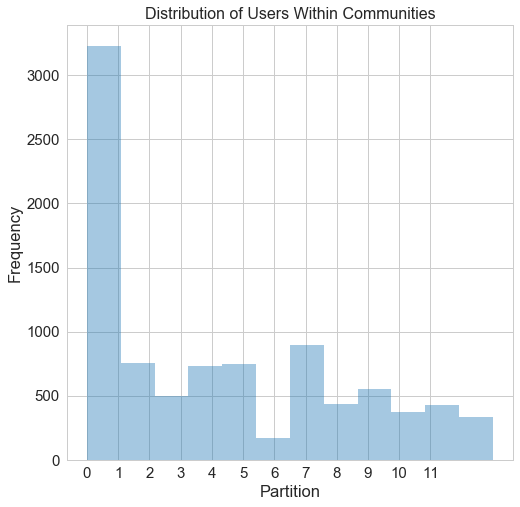

In [24]:
plot_dist(partitions_df, np.arange(0,12,1), 12);

In [25]:
partitions_df['partition'].value_counts()

1     2533
7      896
2      759
5      747
4      729
0      698
9      554
3      495
8      434
11     424
10     370
12     307
6      172
13      28
Name: partition, dtype: int64

### Island Method

Apply the Island Method to the user network given the large number of nodes.  

In [26]:
# Trim edges function is taken directly from SNABook

def trim_edges(g, weight=1):
    """
    Remove edges with weights less then a threshold parameter ("weight")
    """
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
     
    return g2
            

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

Apply the Island Method to determine the minimim water level for trimming the network.  Below, we're using a minimum weight between user nodes of 3. 

In [ ]:
## Apply Island Analysis on the user nodes
cc = list(nx.connected_component_subgraphs(U))[0]
islands = island_method(cc, 3)

In [28]:
print ('Weight  Users  Groups')
for i in islands:
   print(' {}     {}   {}  '.format(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))

Weight  Users  Groups
 1     2685   2  
 12     44   2  
 23     9   1  
 34     2   1  


In [31]:
# apply a minimum weight 3 water level and create the trimmed user subgraph
Usub = trim_edges(U, 3)

In [32]:
print(nx.info(Usub))

Name: 
Type: Graph
Number of nodes: 601
Number of edges: 5562
Average degree:  18.5092


#### Recalculate Communities following the network trimming.

In [33]:
partitions = community_louvain.best_partition(Usub)
set(partitions.values())

{0, 1, 2, 3, 4, 5}

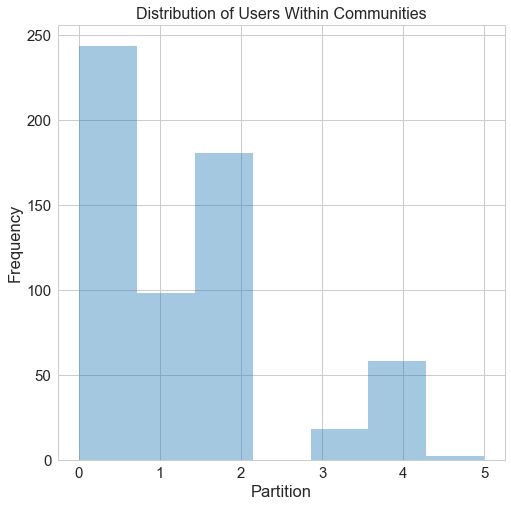

In [34]:
partitions_df = pd.DataFrame({'partition':partitions})
plot_dist(partitions_df, np.arange(0,6,1), 7);

#### Note above that largest community paritition from the original histogram has dropped significantly after networking trimming, indicating that many of the nodes had an edge weight less than 3.

### Calculate Centrality Measures and Save them on the User node

In [36]:
deg = nx.degree_centrality(Usub)                       # Run degree centrality         

In [40]:
bet = nx.betweenness_centrality(Usub)                  # Run betweenness centrality

In [39]:
eig = nx.eigenvector_centrality(Usub)                  # Run eigenvector centrality

In [41]:
clos = nx.closeness_centrality(Usub) 

In [42]:
# Assign each to an attribute in your network
nx.set_node_attributes(Usub, 'degree', deg)
nx.set_node_attributes(Usub, 'eigenvector', eig)
nx.set_node_attributes(Usub, 'betweenness', bet)
nx.set_node_attributes(Usub, 'closeness', clos)
nx.set_node_attributes(Usub, 'partition', partitions)

In [50]:
# Create a Usub dataframe with the node ID and metrics

# first assign the username to the Usub network
for n in Usub.nodes():
    #apply the name from G as an attribute of sub_G
    Usub.node[n]['name'] = G.node[n]['name'] 


In [53]:
graph = Usub.nodes(data = True)

data={}

data['node'] = [x[0] for x in graph]
data['name'] =[x[1]['name'] for x in graph]
data['degree'] = [x[1]['degree'] for x in graph]
data['eigenvector'] = [x[1]['eigenvector'] for x in graph]
data['betweenness'] = [x[1]['betweenness'] for x in graph]
data['closeness'] = [x[1]['closeness'] for x in graph]
data['partition'] = [x[1]['partition'] for x in graph]

# load into a data frame
usub_df = pd.DataFrame(data)
usub_df = usub_df.set_index(['node'])


#### Who are the most important users based on eigenvector centrality?

In [56]:
usub_df.sort_values(by=['eigenvector'], ascending=[0]).head(10)

,betweenness,closeness,degree,eigenvector,name,partition
node,,,,,,
9OZH1Ecw-qUkCW5MS0NefA,0.191210,0.669643,0.508333,0.271502,Laura,0
UnGPr6ZnGe9YOSZRopnS5g,0.103585,0.606673,0.365000,0.203992,Anne,0
q4_kY8bBeigYPVS0Ak7QGg,0.076966,0.598802,0.341667,0.187603,Shawn,2
SlKJNLm1SQdgaaKtqD--1w,0.062811,0.587084,0.306667,0.184597,MaryAlice,0
nEYPahVwXGD2Pjvgkm7QqQ,0.060108,0.585938,0.313333,0.181443,Rachel,2
o9XGClSBzCsQxbcCzTPdnQ,0.045037,0.582524,0.296667,0.178876,Carly,4
kWkgwRxqWD-h260dMTkHUA,0.041658,0.584795,0.306667,0.178713,Jason,2
59A-ZxUMOgIl2MAnySh-Aw,0.048693,0.573614,0.273333,0.176259,Joseph,0
J_q8jN623uew8ZzMChXBCA,0.049239,0.583090,0.303333,0.175975,David,2


#### Examination of Important Users Across Communities

Let's redraw the User subgraph now that the number of nodes has been reduced.

In [ ]:
plt.axis("off")

values = [partitions.get(node) for node in Usub.nodes()]
weights = [edata['weight']/100 for f,t,edata in Usub.edges(data=True)]
spring_pos = nx.spring_layout(Usub)
ns = [v for v in Usub.degree().values()]

nx.draw_networkx(Usub, pos = spring_pos,   width=weights, edge_color=weights,
                 cmap = plt.get_cmap("jet"), node_color = values, 
                 node_size = ns, with_labels = False)

In [145]:
values = [partitions.get(node) for node in U.nodes()]
spring_pos = nx.spring_layout(U)
plt.axis("off")
nx.draw_networkx(U, pos = spring_pos, 
                 cmap = plt.get_cmap("jet"), node_color = values, 
                 node_size = 35, with_labels = False)

MemoryError: 

Let's focus on the key users within each community, using eigenvector centrality as a measure of importance.  Let's re-establish the existing communities in the user subgraph.

In [122]:
set(partitions.values())

{0, 1, 2, 3, 4, 5, 6}

In [67]:
# function to return the top n users within each community based on ev centrality

def get_top_users_by_community(g, partitions, top=3):
    lst = []
    
    for i, n in enumerate(partitions):
    
        # First get a list of just the nodes in that class
        class_nodes = [n for n in g.nodes() if g.node[n]['partition'] == i]

        # Then create a dictionary of the eigenvector centralities of those nodes
        class_eigenvector = {n:g.node[n]['eigenvector'] for n in class_nodes}

        # Then sort that dictionary and print the first 5 results
        class_sorted_by_eigenvector = sorted(class_eigenvector.items(), key=itemgetter(1), reverse=True)

        print("Parition {} Sorted by Eigenvector Centrality:".format(i))
        for node in class_sorted_by_eigenvector[:top]:
           print("Name:", node[0], "| Eigenvector Centrality:", node[1])
           lst.append([i, node[0], node[1]])
    
    return lst
    

In [193]:
top = get_top_users_by_community(Usub, set(partitions.values()), 1)

top_df = pd.DataFrame.from_dict(top)
top_df.columns =['partition', 'user_id', 'eigenvector']
top_df = top_df.set_index(['user_id'])


Parition 0 Sorted by Eigenvector Centrality:
Name: 9OZH1Ecw-qUkCW5MS0NefA | Eigenvector Centrality: 0.27150163681392625
Parition 1 Sorted by Eigenvector Centrality:
Name: tH4brXlghqKn_9GbahrMTQ | Eigenvector Centrality: 0.14680485743921515
Parition 2 Sorted by Eigenvector Centrality:
Name: q4_kY8bBeigYPVS0Ak7QGg | Eigenvector Centrality: 0.18760271827581193
Parition 3 Sorted by Eigenvector Centrality:
Name: 0P58MD0FRVI6pTVKUpd7YA | Eigenvector Centrality: 0.16903348942638205
Parition 4 Sorted by Eigenvector Centrality:
Name: o9XGClSBzCsQxbcCzTPdnQ | Eigenvector Centrality: 0.17887596282594181
Parition 5 Sorted by Eigenvector Centrality:
Name: LiVXtHxGX6TjNHsBWeb9KA | Eigenvector Centrality: 0.0025717846268665436


In [194]:
# merge the user dataframe and the sampled metrics dataframe
top_df = pd.merge(usub_df, top_df,right_index=True, left_index=True)

In [196]:
top_df.iloc[:,:6].sort_values(by='partition_x', ascending=1)

,betweenness,closeness,degree,eigenvector_x,name,partition_x
9OZH1Ecw-qUkCW5MS0NefA,0.191210,0.669643,0.508333,0.271502,Laura,0
tH4brXlghqKn_9GbahrMTQ,0.065885,0.578592,0.291667,0.146805,Jocelyn,1
q4_kY8bBeigYPVS0Ak7QGg,0.076966,0.598802,0.341667,0.187603,Shawn,2
0P58MD0FRVI6pTVKUpd7YA,0.045055,0.580271,0.285000,0.169033,Rebecca,3
o9XGClSBzCsQxbcCzTPdnQ,0.045037,0.582524,0.296667,0.178876,Carly,4
LiVXtHxGX6TjNHsBWeb9KA,0.000065,0.375469,0.005000,0.002572,Justin,5


#### Let's draw the the graph of the businesses the top users in each community are connected to through ratings.

In [ ]:
# create a function to find all the neighbors of a given user node.  In this case the neighbors will be
# businesses from the bipartite graph.
def create_subgraph(subgraph, start_node):
        
    for n in G.neighbors_iter(start_node):
        subgraph.add_path([start_node,n])
   
    return subgraph

In [80]:
# create a subgraph of the top users by community.  This process takes each user and find his/her business 
# neigbhors in the bipartite graph G

df = pd.DataFrame.from_dict(top)
df.columns =['partition', 'user_id', 'eigenvector']

#df[df.partition==0]

sub_G = nx.Graph()

for index, row in df.iterrows(): 
    create_subgraph(sub_G, row['user_id'])
   

for n in sub_G.nodes():
    #apply the name from G as an attribute of sub_G
    sub_G.node[n]['name'] = G.node[n]['name']
    sub_G.node[n]['neighborhoods'] = G.node[n]['neighborhoods']
    

#### Top Community Users - Businesses Graph

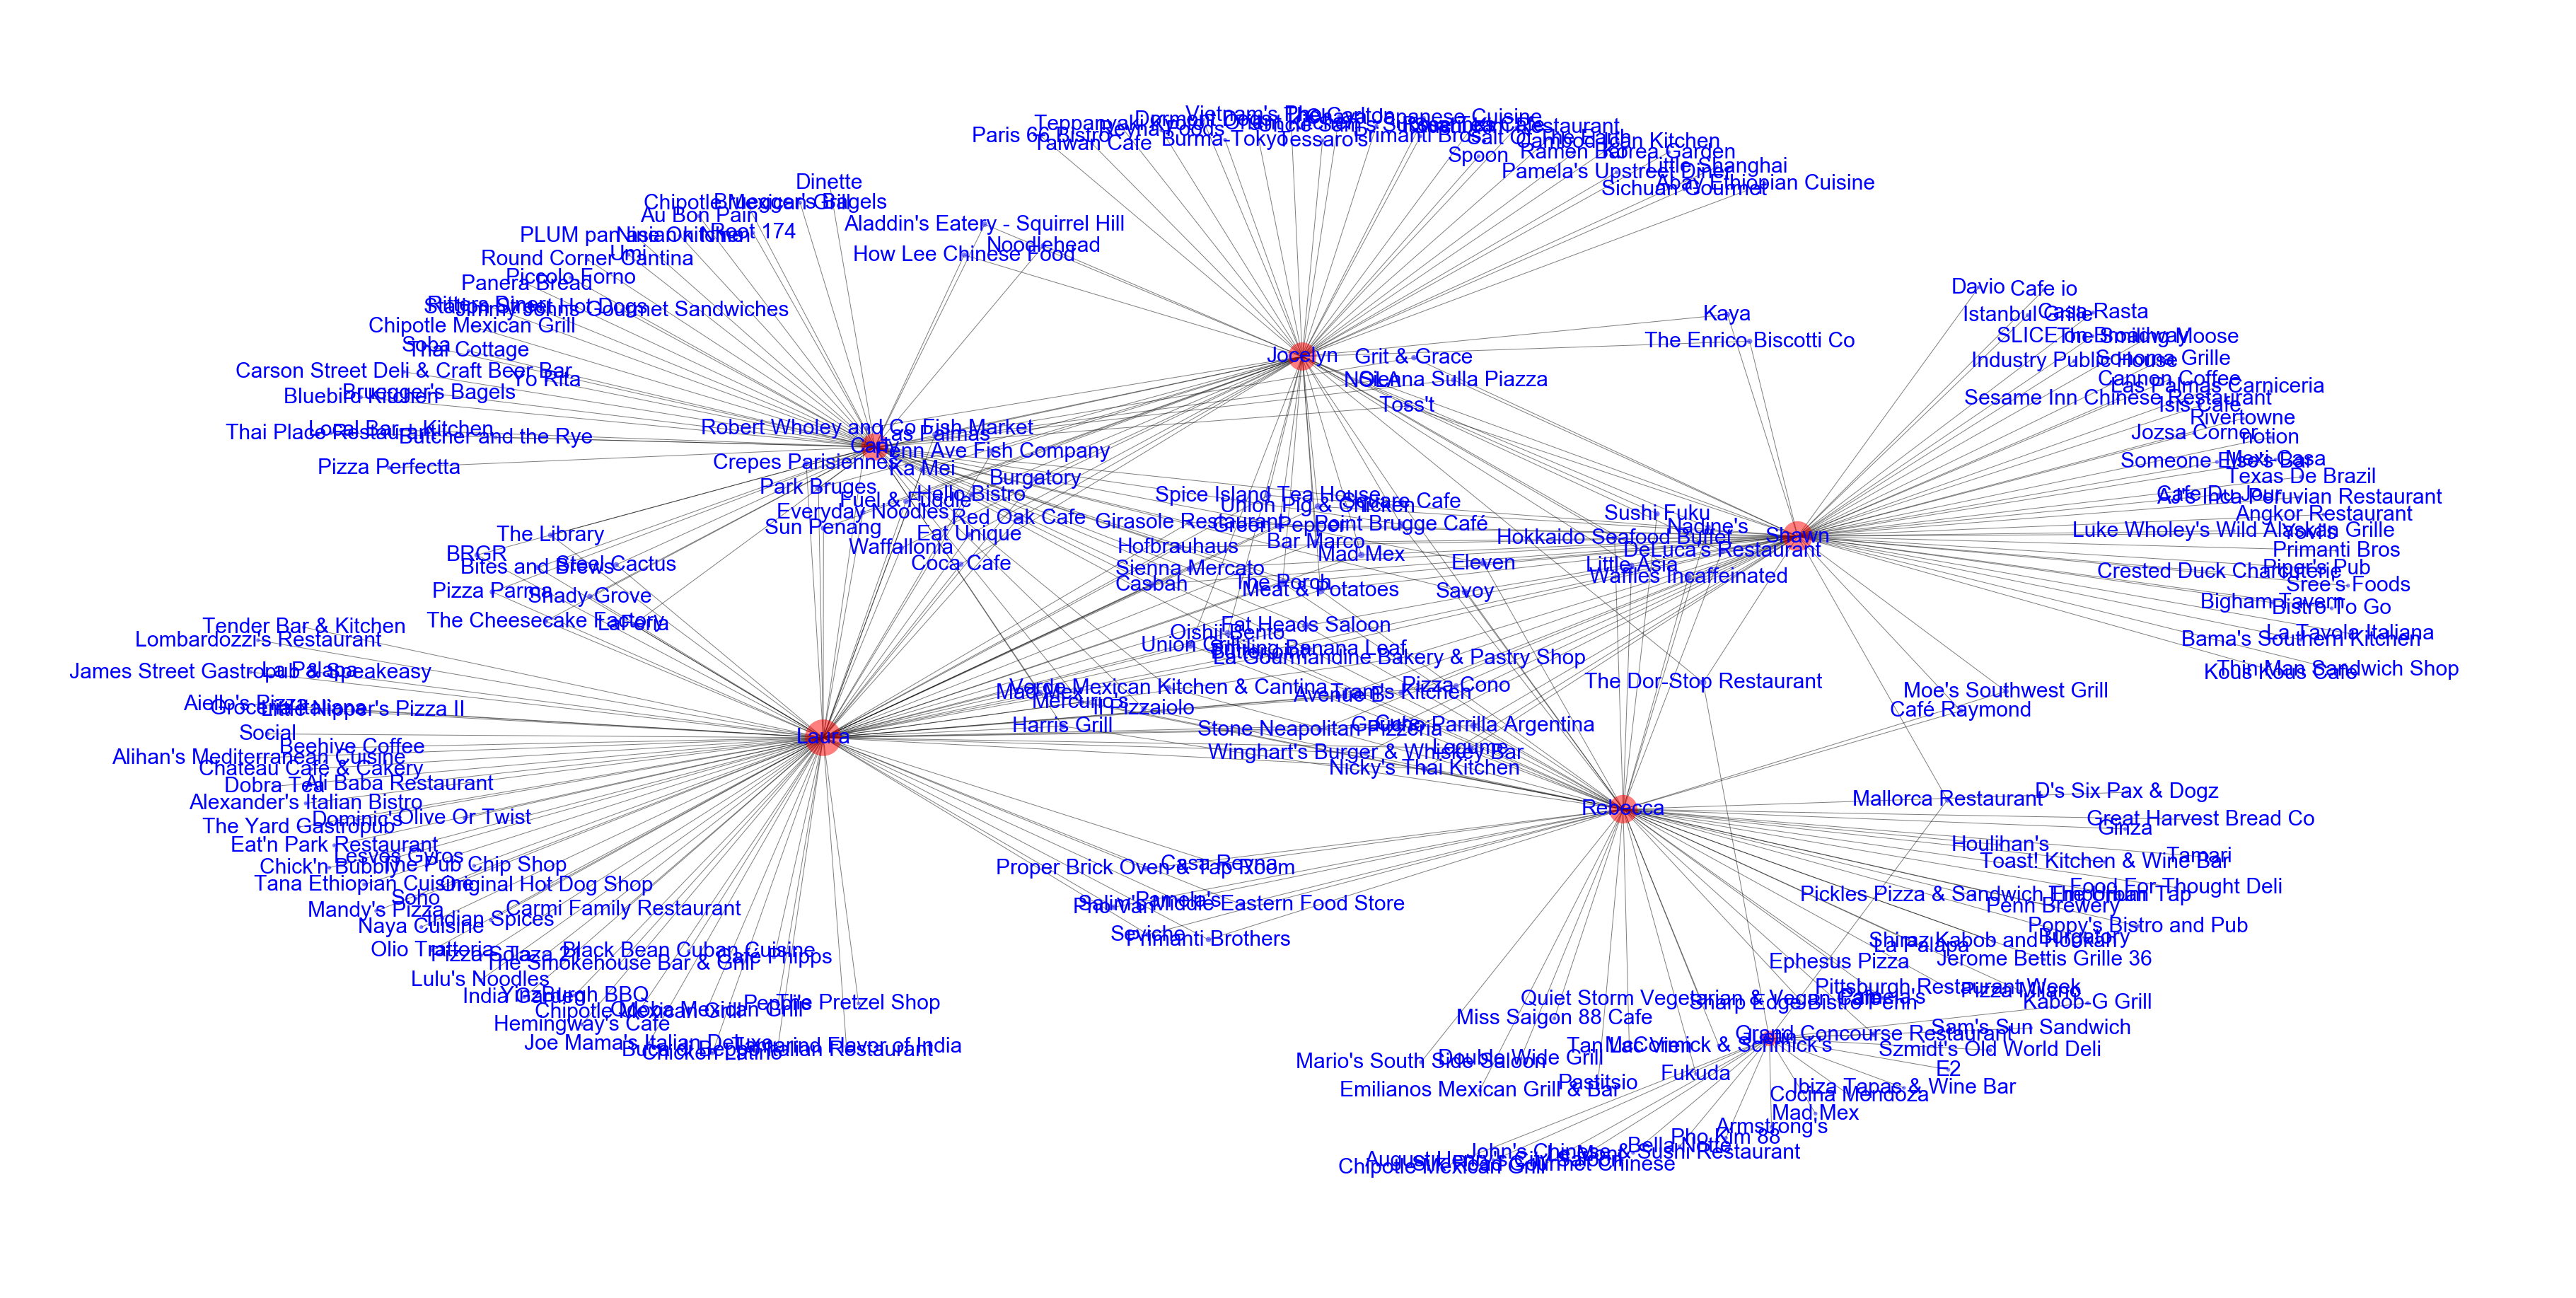

In [81]:

l = df['user_id'].values.tolist()
   
colors=[]
labels=[]

for n, d in sub_G.nodes(data=True):
   
    if n in l:
        colors.append('r')
    else:
        colors.append('b')
     


labels = nx.get_node_attributes(sub_G, "name")

spring_pos = nx.spring_layout(sub_G)

ns = [v*25 for v in sub_G.degree().values()]


plt.figure(figsize=(50,25))

nx.draw(sub_G, pos=spring_pos,
        with_labels=False, 
        edge_color='black', 
        node_color=colors, 
        vmin=1.0, vmax=5.0, 
        alpha=.5,  
        node_size=ns
        ) 

nx.draw_networkx_labels(sub_G, spring_pos, labels, font_size=30, font_color='blue')

plt.show()            

One immediate takeaway from the graph above is that there the amount of overlap in common business reviews is surprisingly lower than one might expect.  This seems counter to intuition that there would be higher similarity among users and the businesses they're reviewing.

### User Similarity

Let's examine similarity between users to better understand what we're seeing above.  Similarity will be calculated using the Jaccard Similarity method which is defined as Intersection(A, B) / Union(A, B).

In [88]:
import itertools
list(itertools.combinations(df.user_id, 2))

# create the combinations of the top users for similarity scoring
top_users = pd.DataFrame(list(itertools.combinations(df.user_id, 2)), columns=['user1', 'user2'])

top_users['user1_nodes']= np.nan
top_users['user2_nodes']= np.nan
top_users['common_nodes']= np.nan
top_users['total_nodes']= np.nan
top_users['similarity']= np.nan


Calculate Similarity scores among the top community users.

In [93]:
for index, row in top_users.iterrows():
    n1 = set(G.neighbors(row['user1'])) #find the business neighbors of user1
    n2 = set(G.neighbors(row['user2'])) #find the business neighbors of user1
    
    top_users.loc[index, 'user1_nodes'] = len(n1)
    top_users.loc[index, 'user2_nodes'] = len(n2)
    top_users.loc[index, 'common_nodes'] = len(set(n1).intersection(n2))
    top_users.loc[index, 'total_nodes'] = len(set(n1).union(n2))
    
    # calculate similarity using Jaccard Similarity
    # = Intersection(A, B) / Union(A, B)
    top_users.loc[index, 'similarity'] = row['common_nodes']/row['total_nodes']

In [94]:
top_users.sort_values(by='similarity', ascending=0)

,user1,user2,common_nodes,total_nodes,similarity,user1_nodes,user2_nodes
0,9OZH1Ecw-qUkCW5MS0NefA,tH4brXlghqKn_9GbahrMTQ,24.0,143.0,0.167832,105.0,62.0
1,9OZH1Ecw-qUkCW5MS0NefA,q4_kY8bBeigYPVS0Ak7QGg,24.0,152.0,0.157895,105.0,71.0
3,9OZH1Ecw-qUkCW5MS0NefA,o9XGClSBzCsQxbcCzTPdnQ,21.0,143.0,0.146853,105.0,59.0
2,9OZH1Ecw-qUkCW5MS0NefA,0P58MD0FRVI6pTVKUpd7YA,20.0,149.0,0.134228,105.0,64.0
10,q4_kY8bBeigYPVS0Ak7QGg,o9XGClSBzCsQxbcCzTPdnQ,15.0,115.0,0.130435,71.0,59.0
12,0P58MD0FRVI6pTVKUpd7YA,o9XGClSBzCsQxbcCzTPdnQ,14.0,109.0,0.128440,64.0,59.0
9,q4_kY8bBeigYPVS0Ak7QGg,0P58MD0FRVI6pTVKUpd7YA,14.0,121.0,0.115702,71.0,64.0
6,tH4brXlghqKn_9GbahrMTQ,0P58MD0FRVI6pTVKUpd7YA,12.0,114.0,0.105263,62.0,64.0
5,tH4brXlghqKn_9GbahrMTQ,q4_kY8bBeigYPVS0Ak7QGg,12.0,121.0,0.099174,62.0,71.0
7,tH4brXlghqKn_9GbahrMTQ,o9XGClSBzCsQxbcCzTPdnQ,8.0,113.0,0.070796,62.0,59.0


__Looking at the similarity scores above, we can see that the top users across the communities showing high similarity scores.__

Does this hold true for the larger user subgraph?  Let's randomly sample some users from the subgraph and apply a the same approach for similarity.

In [95]:
import random

# randomly sample 100 users within the network
random_nodes = random.sample(Usub.nodes(), 100)

usub_nodes_list = list(itertools.combinations(random_nodes, 2))

all_users = pd.DataFrame(usub_nodes_list, columns=['user1', 'user2'])
   
all_users['user1_nodes']= np.nan
all_users['user2_nodes']= np.nan    
all_users['common_nodes']= np.nan
all_users['total_nodes']= np.nan
all_users['similarity']= np.nan
all_users.shape


(4950, 5)

In [96]:
all_users.head()

,user1,user2,common_nodes,total_nodes,similarity
0,2CsP7qVLTNy4FPGeKGl-KA,0_6wb6dI4ak54ivvc6v_Xw,NaN,NaN,NaN
1,2CsP7qVLTNy4FPGeKGl-KA,fBdl02j2Yp8glZ_8woQzoA,NaN,NaN,NaN
2,2CsP7qVLTNy4FPGeKGl-KA,pxMn35BEp--FYuJYfLY_gA,NaN,NaN,NaN
3,2CsP7qVLTNy4FPGeKGl-KA,PCB6Da8IsLWYL5K5E72Mvg,NaN,NaN,NaN
4,2CsP7qVLTNy4FPGeKGl-KA,tQjvFcsbpUre8zRRpK7zMw,NaN,NaN,NaN


#### Calculate Similarity for the randomly sampled users

In [101]:
for index, row in all_users.iterrows():
    n1 = set(G.neighbors(row['user1'])) #find the business neighbors of user1
    n2 = set(G.neighbors(row['user2'])) #find the business neighbors of user1
    
    all_users.loc[index, 'user1_nodes'] = len(n1)
    all_users.loc[index, 'user2_nodes'] = len(n2)
    all_users.loc[index, 'common_nodes'] = len(set(n1).intersection(n2))
    all_users.loc[index, 'total_nodes'] = len(set(n1).union(n2))
    
    # calculate similarity using Jaccard Similarity
    # = Intersection(A, B) / Union(A, B)
    all_users.loc[index, 'similarity'] = row['common_nodes']/row['total_nodes']


In [102]:
all_users.sort_values(by='similarity', ascending=0).head(10)

,user1,user2,common_nodes,total_nodes,similarity,user1_nodes,user2_nodes
4388,XUXMBPMvlzjcCdzTaOmtjg,iaN3YatnCHZkYuPda0Z-XQ,2.0,7.0,0.285714,4.0,5.0
4254,ZQM9jRu2XrxMJ6N8v5SmeA,bI6bMu0ZsomD-blY_3WL5g,3.0,13.0,0.230769,7.0,9.0
168,0_6wb6dI4ak54ivvc6v_Xw,7jJtsEz3qnpHgThCyMVtfA,2.0,9.0,0.222222,6.0,5.0
3852,lpsFN1DQYBB1YkzKUUlf2w,H8aeIBA4oYYNry0O93cnCw,2.0,10.0,0.200000,6.0,6.0
3353,mOY2XA8fNpR-vAb0q4rBQA,iaN3YatnCHZkYuPda0Z-XQ,2.0,10.0,0.200000,7.0,5.0
3042,D3jHbQTaI27qrIB1xmi3vg,H8aeIBA4oYYNry0O93cnCw,2.0,10.0,0.200000,6.0,6.0
3151,LhgQq1x4n9ardg1PFo8vgg,7jJtsEz3qnpHgThCyMVtfA,2.0,10.0,0.200000,7.0,5.0
3441,JPPhyFE-UE453zA6K0TVgw,_Dhiyfp0JiANkjoEwhgWNg,5.0,26.0,0.192308,25.0,6.0
4624,rOs5ezqPyecAHV3WM-c9Jg,iaN3YatnCHZkYuPda0Z-XQ,4.0,22.0,0.181818,21.0,5.0
4556,7jJtsEz3qnpHgThCyMVtfA,n7QwJpmveBfVg2wZ3SJIOA,2.0,11.0,0.181818,5.0,8.0


In [104]:
# users with more than 50 business nodes between them
all_users[all_users.total_nodes > 50].sort_values(by='similarity', ascending=0).head(10)

,user1,user2,common_nodes,total_nodes,similarity,user1_nodes,user2_nodes
2941,HXhYt_M1nDOfFse0_QlLww,JPPhyFE-UE453zA6K0TVgw,10.0,57.0,0.175439,42.0,25.0
2950,HXhYt_M1nDOfFse0_QlLww,Sdy0RPXf0nxZ-15Zb_Fxmg,8.0,55.0,0.145455,42.0,21.0
530,tQjvFcsbpUre8zRRpK7zMw,FP79xn8H2XXnMksRuP5l6A,6.0,52.0,0.115385,25.0,33.0
4795,MA713-m2wv51bww8LN2fSA,5z6ZXMg3-XO3UmSxpZWBUA,6.0,53.0,0.113208,38.0,21.0
1813,2rSeth60_CuWN3ZJ4k41lg,JPPhyFE-UE453zA6K0TVgw,6.0,60.0,0.100000,41.0,25.0
3416,JPPhyFE-UE453zA6K0TVgw,FP79xn8H2XXnMksRuP5l6A,5.0,53.0,0.094340,25.0,33.0
2330,c3P8lRnyv_beqsg_efD0ew,HXhYt_M1nDOfFse0_QlLww,5.0,53.0,0.094340,16.0,42.0
4606,rOs5ezqPyecAHV3WM-c9Jg,MA713-m2wv51bww8LN2fSA,5.0,54.0,0.092593,21.0,38.0
1820,2rSeth60_CuWN3ZJ4k41lg,FP79xn8H2XXnMksRuP5l6A,6.0,68.0,0.088235,41.0,33.0
4899,MSuyK2p8G9hEqyWf5IgnYQ,6rR83Un71x8KWnW9-oJfqA,5.0,57.0,0.087719,37.0,25.0


Let's assign a single simiilarity value to each user within the network.  One approach might be to take the mean of all a user's similarity scores against other users.  This would represent a user's mean similarity within this network as compared to other users.

In [112]:
all_user_metrics = all_users.groupby(['user1'], as_index=False).mean().sort_values(by='similarity', ascending=0)

In [113]:
all_user_metrics.head(10)

all_user_metrics = all_user_metrics.set_index(['user1'])

In [120]:
# merge the user dataframe and the sampled metrics dataframe
sampled_users = pd.merge(usub_df, all_user_metrics,right_index=True, left_index=True)

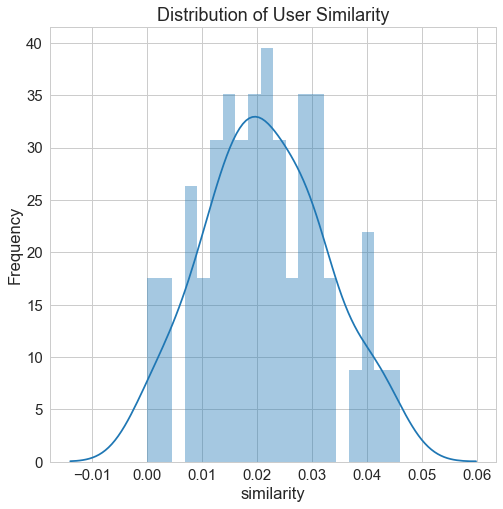

In [121]:
# Plot the distribution of users within each community
sns.set_style("whitegrid")    # Set style for seaborn output
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(8,8))
#plt.xticks(range) #np.arange(0,15,1))
plt.xlabel("Partition")
plt.ylabel("Frequency")
plt.title("Distribution of User Similarity", fontsize=18)

sns.distplot(sampled_users.similarity, bins=20, kde=True, rug=False);

#### The distribution above appears to be fairly normal with a mean around 0.2.  

Let's test for normality:

In [139]:
from scipy.stats import normaltest
from matplotlib import pyplot

value, p = normaltest(sampled_users.similarity)
print(value, p)

if p >= 0.05:
    print('\nSimilarity scores are likely normally distributed')
else:
    print('\nSimilarity scores are not likely normally distributed')

1.50046007562 0.47225790307

Similarity scores are likely normally distributed


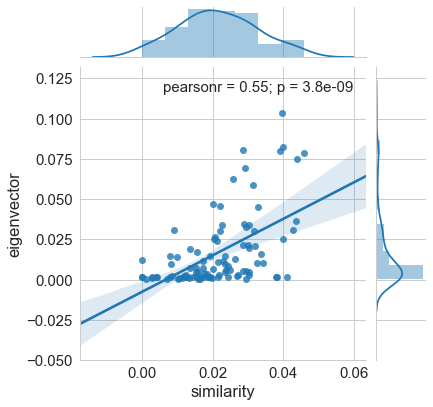

In [128]:
# eigenvector
sns.jointplot(x="similarity", y="eigenvector", data=sampled_users, kind="reg");

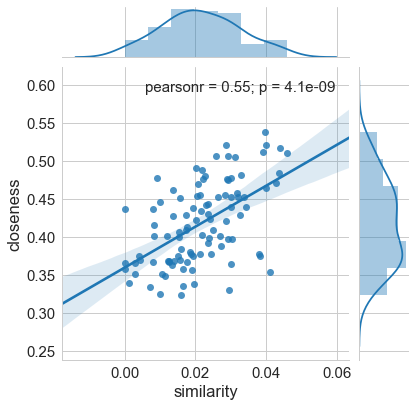

In [140]:
# eigenvector
sns.jointplot(x="similarity", y="closeness", data=sampled_users, kind="reg");